In [127]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import csv
import sys
import pandas as pd
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# Получаем входные значения
arguments = sys.argv

#if arguments[1] == "cny":
dataset_path = "..\\dataset\\uan20years.csv"
    # граница тренировочных и валидационных данных
TRAIN_SPLIT = 4450
    # кол-во обучающих данных
EVALUATION_INTERVAL = 4000
model_save = "..\\model\cny_model.keras"
#elif arguments[1] == "aed":
#    dataset_path = "..\\dataset\\aed20years.csv"
    # граница тренировочных и валидационных данных
#    TRAIN_SPLIT = 400
    # кол-во обучающих данных
#    EVALUATION_INTERVAL = 390
#    model_save = "..\\model\aed_model.keras"
#else:
#    print("Нет входных аргументов")
#    quit()


# кол-во эпох обучения
EPOCHS = 100
# настройки для обучения
BATCH_SIZE = 256
BUFFER_SIZE = 10000

        
# Загрузка данных из CSV файла
df = pd.read_csv(dataset_path, on_bad_lines='skip', sep=';')

# Преобразование значений столбца 'curs' из строки в число с корректным разделителем
df['curs'] = df['curs'].str.replace(',', '.').astype(float)
# Применение логики для разделения значений столбцов 'nominal' и 'curs'
df['curs'] = df.apply(lambda row: row['curs'] / 10.0 if row['nominal'] == 10 else row['curs'], axis=1)

df['nominal'] = df['nominal'].apply(lambda x: x / 10 if x == 10 else x)

# Переворачивание порядка столбцов, кроме первого
df.iloc[:, 1:] = df.iloc[:, 1:][::-1].values
df.head()


,nominal,data,curs,cdx
0,1.0,01.01.2000,3.261,Китайский юань
1,1.0,01.02.2000,3.449,Китайский юань
2,1.0,01.03.2000,3.462,Китайский юань
3,1.0,01.04.2000,3.438,Китайский юань
4,1.0,01.05.2000,3.434,Китайский юань


In [128]:
# Функция подготовки данных для входа в рекурентную сеть
def univariate_data(dataset, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(np.reshape(dataset[indices], (history_size, 1)))

    labels.append(dataset[i:i+target_size])

  return np.array(data), np.array(labels)

In [129]:
print(df.columns)

Index(['nominal', 'data', 'curs', 'cdx'], dtype='object')


In [130]:
# извлекаем курс и индексируем по дате
uni_data = df['curs']
uni_data.index = df['data']
uni_data.head()

data
01.01.2000    3.261
01.02.2000    3.449
01.03.2000    3.462
01.04.2000    3.438
01.05.2000    3.434
Name: curs, dtype: float64

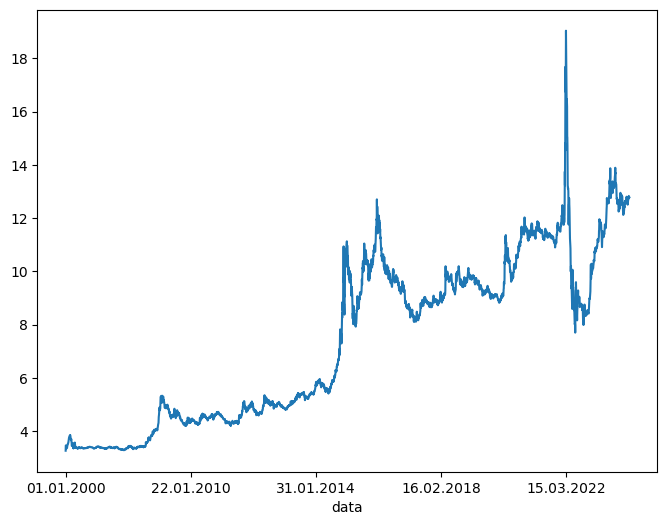

In [131]:
# график курса за всё время измерений
uni_data.plot(subplots=True)
uni_data = uni_data.values

In [132]:
# номализация данных
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [133]:
past_history = 30
future_target = 7
STEP = 1

x_train_uni, y_train_uni = univariate_data(uni_data, 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_uni, y_val_uni = univariate_data(uni_data,
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [134]:
print ('Single window of past history : {}'.format(x_train_uni[0].shape))
print ('\n Target curs to predict : {}'.format(y_train_uni[0].shape))

Single window of past history : (30, 1)

 Target curs to predict : (7,)


In [135]:
# подготовка данных для модели
train_data_uni = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_data_uni = train_data_uni.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_uni = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_data_uni = val_data_uni.batch(BATCH_SIZE).repeat()

In [138]:
# сборка слоёв модели
uni_step_model = tf.keras.models.Sequential()
uni_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_uni.shape[-2:]))
uni_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
uni_step_model.add(tf.keras.layers.Dense(7))

uni_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [139]:
# Проверка формы данных после преобразования
print(x_train_uni.shape)
for x, y in val_data_uni.take(1):
  print (uni_step_model.predict(x).shape)

(4420, 30, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
(18, 7)


In [140]:
# обучение модели
uni_step_history = uni_step_model.fit(train_data_uni, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_uni,
                                          validation_steps=50)

Epoch 1/100
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 59s 14ms/step - loss: 0.1057 - val_loss: 0.0423
Epoch 2/100
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 59s 15ms/step - loss: 0.0431 - val_loss: 0.0405
Epoch 3/100
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 71s 18ms/step - loss: 0.0388 - val_loss: 0.0442
Epoch 4/100
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 1348s 337ms/step - loss: 0.0369 - val_loss: 0.0917
Epoch 5/100
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 52s 13ms/step - loss: 0.0354 - val_loss: 0.0664
Epoch 6/100
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 58s 14ms/step - loss: 0.0332 - val_loss: 0.0551
Epoch 7/100
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 68s 17ms/step - loss: 0.0315 - val_loss: 0.0695
Epoch 8/100
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 62s 15ms/step - loss: 0.0304 - val_loss: 0.0804
Epoch 9/100
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 58s 14ms/step - loss: 0.0296 - val_loss: 0.1197
Epoch 10/100
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 58s 14ms/step - loss: 0.0288 - val_loss: 0.0655
Epoch 11/100
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 58s 14ms/step - loss: 0.0279 - val_loss: 0

4000/4000 ━━━━━━━━━━━━━━━━━━━━ 67s 17ms/step - loss: 0.0132 - val_loss: 0.0684
Epoch 67/100
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 65s 16ms/step - loss: 0.0132 - val_loss: 0.0616
Epoch 68/100
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 64s 16ms/step - loss: 0.0131 - val_loss: 0.0825
Epoch 69/100
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 64s 16ms/step - loss: 0.0131 - val_loss: 0.0742
Epoch 70/100
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 64s 16ms/step - loss: 0.0130 - val_loss: 0.0822
Epoch 71/100
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 64s 16ms/step - loss: 0.0129 - val_loss: 0.0639
Epoch 72/100
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 63s 16ms/step - loss: 0.0129 - val_loss: 0.0637
Epoch 73/100
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 86s 21ms/step - loss: 0.0128 - val_loss: 0.0755
Epoch 74/100
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 88s 22ms/step - loss: 0.0128 - val_loss: 0.0631
Epoch 75/100
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 88s 22ms/step - loss: 0.0127 - val_loss: 0.0839
Epoch 76/100
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 87s 22ms/step - loss: 0.0127 - val_loss: 0.0816
E

In [141]:
for x, y in val_data_uni.take(1):
  print((uni_step_model.predict(x)[0]* uni_train_std) + uni_train_mean)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
[12.986162  13.06591   13.01759   12.786568  12.54449   12.544125
 12.7165985]


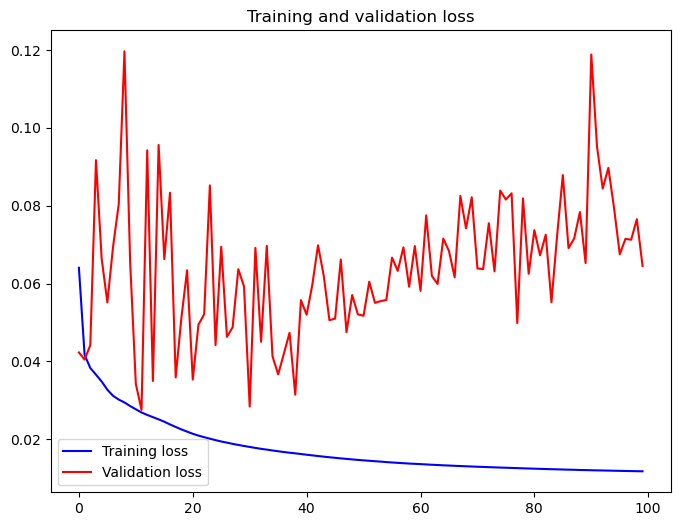

In [142]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

plot_train_history(uni_step_history, 'Training and validation loss')

In [143]:
# функция для отрисовки графика
def create_time_steps(length):
  return list(range(-length, 0))

def uni_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


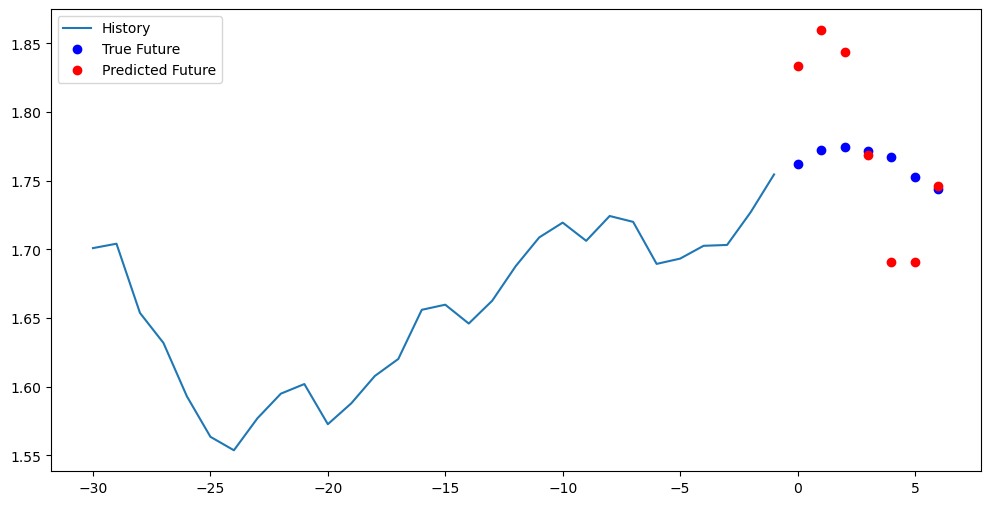

In [144]:
for x, y in val_data_uni.take(1):
  uni_step_plot(x[0], y[0], uni_step_model.predict(x)[0])

In [145]:
# Сохранение модели
uni_step_model.save(model_save)